### Datasources
We want to find causes of the contextual indicator, specifically:
- Share of young adults aged 18-34 living with their parents by age and sex - EU-SILC survey (Eurostat: [ilc_lvps08])

For this we obtain variables from these sources:
- Young immigrants by sex, age and country of birth (Eurostat: [yth_demo_070])	
- Unemployment rates by sex, age and citizenship (%) [lfsa_urgan]
- Mobile students from abroad enrolled by education level, sex and country of origin [educ_uoe_mobs02]
    - Degree mobile students are referred to as just ‘mobile students’ in UOE learning mobility tables. Degree mobility means that students/graduates are/were enrolled as regular students in any semester/term of a programme taught in the country of destination with the intention of graduating from it in the country of destination.
- (Optional) 	Mobile students from abroad enrolled by education level, sex and field of education [educ_uoe_mobs01]
    - *Note: anne-louise used educ_momo_fld for 'Inward mobile students as percentage of student population in the host country (%)'
- Students enrolled in tertiary education by education level, programme orientation, sex and age (abosulte number) [educ_uoe_enrt02]
- Share of young adults aged 18-34 living with their parents by self-defined current economic status - EU-SILC survey [ilc_lvps09]
- First-time marrying persons by age and sex [demo_nsinagec]
- Monthly minimum wage as a proportion of average monthly earnings (%) - NACE Rev. 2 (from 2008 onwards) [earn_mw_avgr2]
- HICP - annual data (average index and rate of change) [prc_hicp_aind]
    - Actual rentals for housing 
    - Total inflation

- Netherlands: Number of renting homes (%) (CBS)
    - *Note: we should also include the type of rent (social (& student), free sector etc.)
- Netherlands: Student debt (in euros) (CBS)


In [109]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from country_codes import eurostat_dictionary
import eurostat
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor

from warnings import filterwarnings
filterwarnings('ignore')

EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

COUNTRY = "Netherlands"

# Outcome variable
def youth_at_home(COUNTRY, SEX = None, AGE = None):
    df_n = eurostat.get_data_df('ilc_lvps08') # YOUNG PEOPLE LIVING AT HOME
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    return df_n


# Unemployment by age, sex, citizenship
def unemployment(COUNTRY):
    df_n = eurostat.get_data_df('lfsa_urgan') 
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['citizen'] =='NAT']
    
    df_n.drop(['geo', 'freq', 'unit', 'citizen'],axis=1,inplace=True)
    ages = ['Y15-19', 'Y15-24', 'Y15-29', 'Y15-39', 'Y20-24', 'Y20-29', 'Y25-29', 'Y30-34' ]
    # keep only these ages
    df_n.set_index(['sex', 'age', 'country'], inplace=True)
    df_n= df_n[df_n.index.get_level_values('age').isin(ages)]
    df_n= df_n[['2010', '2020']]
    return df_n


# Mobile students from abroad enrolled by education level, sex and country of origin
def mobile_students_from_abroad(COUNTRY):
    df_n = eurostat.get_data_df('educ_uoe_mobs02')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['partner', 'freq', 'unit'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['isced11'] == 'ED5-8']
    df_n = df_n[df_n['sex'] == 'T'] 
    df_n.drop(['isced11'],axis=1,inplace=True)
    df_n.set_index(['sex', 'country'], inplace=True)
    df_n = df_n.sum(axis=0)
    df_n = df_n.T
    return df_n

# Inward mobile students as percentage of student population in the host country (%)
def students_from_abroad_by_level_and_field(COUNTRY):
    df_n = eurostat.get_data_df('educ_momo_fld')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    # df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['field'] == 'TOTAL']
    df_n = df_n[df_n['indic_ed'] == 'MS01_2P']

    return df_n

# Gereguleerde huurwoningen (%) CBS
def huurwoningen_NL():
    file_path = 'table_tabel-1c5c9e98-d6b6-4a91-99a4-52fa29f14feb.csv'
    huurwoningen_df= pd.read_csv(file_path, sep=',')
    huurwoningen_df = huurwoningen_df[['Gereguleerde huurwoningen1) (%)', 'categories1']]
    huurwoningen_df = huurwoningen_df[huurwoningen_df['categories1'].isin(['2012', '2021'])]
    return huurwoningen_df

# Average student debt per age category
def student_debt():
    file_path = 'table_tabel-ef26b4a9-7b08-42a9-b76c-a50afbfde19c.csv'
    student_debt_df= pd.read_csv(file_path, sep=',')
    student_debt_df = student_debt_df[student_debt_df['Jaar'].isin(['2011', '2020'])]
    return student_debt_df


# Students enrolled in tertiary education by education level, programme orientation, sex and age
# in absolute numbers
def students_tertiary_eduction(COUNTRY):
    df_n = eurostat.get_data_df('educ_uoe_enrt02')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['freq', 'unit'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['isced11'] == 'ED5-8']
    df_n = df_n[df_n['age'] == 'TOTAL']
    df_n.set_index(['sex', 'age', 'country'], inplace=True)

    return df_n

# OUTCOME VARIABLE
# Share of young adults aged 18-34 living with their parents by self-defined current economic status - EU-SILC survey (
def share_young_with_parents(COUNTRY):
    """
    # Employed persons working full-time
    # [EMP_FT]
    # Employed persons working part-time
    # [EMP_PT]
    # Unemployed persons
    # [UNE]
    # Students
    # [EDUC]
    # Other persons outside the labour force (former name: inactive persons)
    # [INAC_OTH]
    """
    df_n = eurostat.get_data_df('ilc_lvps09')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
    df_n.drop(['unit', 'freq'],axis=1,inplace=True)
    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]
    df = df_n[['country', 'age','wstatus', '2010']]
    df_outcome_2010 = df
    df = df_n[['country', 'age','wstatus', '2020']]
    df_outcome_2020 = df
    return df_outcome_2010, df_outcome_2020

def first_time_marrying(COUNTRY):
    df_n = eurostat.get_data_df('demo_nsinagec')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo'],axis=1,inplace=True)
    df_n.drop(['freq'],axis=1,inplace=True)
    # df_n = df_n[df_n['unit'] == 'PC']
    # df_n = df_n[df_n['sex'] == 'T']
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n['age'].unique()

    ages = ['Y25-29', 'Y20-24', 'Y30-34', 'Y15-19']

    df_n.set_index(['age', 'country'], inplace=True)
    df_n= df_n[df_n.index.get_level_values('age').isin(ages)]
    df_n= df_n[['2010', '2020']]
    # Y18-34 : 'Y20-24' + 'Y25-29' + 'Y30-34'
    young_people_married = df_n
    young_people_married = young_people_married.reset_index()
    young_people_married = young_people_married.groupby(['age', 'country']).sum()
    return young_people_married


# Monthly minimum wage as a proportion of average monthly earnings (%) - NACE Rev. 2 (from 2008 onwards)
def minimum_wage(COUNTRY):
    df_n = eurostat.get_data_df('earn_mw_avgr2')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq', 'unit'],axis=1,inplace=True)

    df_n = df_n[df_n['indic_se'] == 'MMW_MEAN_ME_PP']
    df_n = df_n[df_n['country'] == COUNTRY]
    df_n = df_n[df_n['nace_r2'] == 'B-N']

    return df_n

# Rent price evolution
def rent_price_evolution(COUNTRY):
    ''' Rent evolution - Annual average index - Actual rentals for housing'''
    df_n = eurostat.get_data_df('prc_hicp_aind')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]

    df_n = df_n[df_n['coicop'] == 'CP041']
    df_n = df_n[df_n['unit'] == 'INX_A_AVG']
    
    return df_n

def total_inflation(COUNTRY):

    df_n = eurostat.get_data_df('prc_hicp_aind')
    df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

    df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
    df_n.drop(['geo', 'freq'],axis=1,inplace=True)
    df_n = df_n[df_n['country'] == COUNTRY]

    df_n = df_n[df_n['coicop'] == 'CP00']
    df_n = df_n[df_n['unit'] == 'INX_A_AVG']
    return df_n


def calculate_average_student_debt_2011_NL(student_debt_df):
    # Calculate average student debt based on age groups
    student_debt_df_2011 = student_debt_df[student_debt_df['Jaar'] == '2011']
    
    total_student_debt_NL = 9.5 * 1000000000

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '20 tot 25 jaar (1 000 euro)']).replace(',', '.')) * 1000
    average_student_debt_18_24 = val 

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + val
    average_student_debt_18_34 = val / 2

    val = float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + float(str(student_debt_df_2011.loc[student_debt_df_2011.index[0], '30 jaar en ouder (1 000 euro)']).replace(',', '.')) * 1000 
    average_student_debt_25_34 = val / 2

    return average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL



def process_outcome_2010(df_outcome_2010, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df):
    # Adding a new column based on conditions
    df_outcome_2010['unemployment_rate_age_group'] = None
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'unemployment_rate_age_group'] = 5.9
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'unemployment_rate_age_group'] = 10.8
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'unemployment_rate_age_group'] = 3.7
    
    df_outcome_2010['youth_getting_married'] = None
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2010'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2010'][0] + +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2010'][0]
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2010'][0]
    df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2010'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2010'][0]

    df_outcome_2010['rent_price_index'] = rentals_df.iloc[0]['2010']
    df_outcome_2010['inflation_index'] = total_inflation_df.iloc[0]['2010']
    df_outcome_2010['minimum_wage_PC_mean_income'] = minimum_wage_PC.iloc[0]['2010']
    df_outcome_2010['mobile_students_from_abroad'] = mobile_students_from_abroad_df['2013']


    if COUNTRY == 'Netherlands':

        huurwoningen_2012 = huurwoningen_df[huurwoningen_df['categories1'] == '2012']
        df_outcome_2010['PC_eating_fruit'] = None  #15 to 29 YRS	  (24.7)	
        df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'PC_eating_fruit'] = 17.9
        df_outcome_2010['Regulated rental dwellings (%)'] = huurwoningen_2012.loc[huurwoningen_2012.index[0], 'Gereguleerde huurwoningen1) (%)']

        average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL = calculate_average_student_debt_2011_NL(student_debt_df)
        df_outcome_2010['average_student_debt'] = None 
        df_outcome_2010['total_student_debt_NL'] = total_student_debt_NL
        df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-24', 'average_student_debt'] = average_student_debt_18_24
        df_outcome_2010.loc[df_outcome_2010['age'] == 'Y18-34', 'average_student_debt'] = average_student_debt_18_34
        df_outcome_2010.loc[df_outcome_2010['age'] == 'Y25-34', 'average_student_debt'] = average_student_debt_25_34

        df_outcome_2010['gemiddelde_verkoopprijs_woning'] = 239.530 #https://www.cbs.nl/nl-nl/cijfers/detail/83906NED?dl=64BA2
        
    return df_outcome_2010


def calculate_average_student_debt_2020_NL(student_debt_df):
    student_debt_df_2020 = student_debt_df[student_debt_df['Jaar'] == '2020']

    total_student_debt_NL = 23.1 * 1000000000

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '20 tot 25 jaar (1 000 euro)']).replace(',', '.')) * 1000
    average_student_debt_18_24 = val 

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + val
    average_student_debt_18_34 = val / 2

    val = float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '25 tot 30 jaar (1 000 euro)']).replace(',', '.')) * 1000 + float(str(student_debt_df_2020.loc[student_debt_df_2020.index[0], '30 jaar en ouder (1 000 euro)']).replace(',', '.')) * 1000 
    average_student_debt_25_34 = val / 2

    return average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL


def process_outcome_2020(df_outcome_2020, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df):
    # Adding a new column based on conditions
    df_outcome_2020['unemployment_rate_age_group'] = None
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-34', 'unemployment_rate_age_group'] = 5.0
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'unemployment_rate_age_group'] = 8.7
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y25-34', 'unemployment_rate_age_group'] = 3.2

    df_outcome_2020['youth_getting_married'] = None
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2020'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2020'][0] + +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2020'][0]
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y20-24']['2020'][0]
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y25-34', 'youth_getting_married'] = young_people_married[young_people_married.index.get_level_values('age') == 'Y25-29']['2020'][0] +  young_people_married[young_people_married.index.get_level_values('age') == 'Y30-34']['2020'][0]

    df_outcome_2020['rent_price_index'] = rentals_df.iloc[0]['2020']

    df_outcome_2020['PC_eating_fruit'] = None 
    df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'PC_eating_fruit'] = 24.7

    df_outcome_2020['mobile_students_from_abroad']  = mobile_students_from_abroad_df['2020']

    df_outcome_2020['minimum_wage_PC_mean_income'] = minimum_wage_PC.iloc[0]['2020']
    
    df_outcome_2020['inflation_index'] = total_inflation_df.iloc[0]['2020']


    if COUNTRY == 'Netherlands':

        huurwoningen_2021 = huurwoningen_df[huurwoningen_df['categories1'] == '2021']
        df_outcome_2020['Regulated rental dwellings (%)'] = huurwoningen_2021.loc[huurwoningen_2021.index[0], 'Gereguleerde huurwoningen1) (%)'] 

        df_outcome_2020['average_student_debt'] = None
        average_student_debt_18_24, average_student_debt_18_34, average_student_debt_25_34, total_student_debt_NL = calculate_average_student_debt_2020_NL(student_debt_df)
        df_outcome_2020['total_student_debt_NL'] = total_student_debt_NL
        df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-24', 'average_student_debt'] = average_student_debt_18_24
        df_outcome_2020.loc[df_outcome_2020['age'] == 'Y18-34', 'average_student_debt'] = average_student_debt_18_34
        df_outcome_2020.loc[df_outcome_2020['age'] == 'Y25-34', 'average_student_debt'] = average_student_debt_25_34

        df_outcome_2020['gemiddelde_verkoopprijs_woning'] = 334.488
    return df_outcome_2020


def process_country(COUNTRY):
    total_inflation_df = total_inflation(COUNTRY)
    rentals_df = rent_price_evolution(COUNTRY)
    
    minimum_wage_PC = minimum_wage(COUNTRY)
    young_people_married = first_time_marrying(COUNTRY)
    tertiary_education = students_tertiary_eduction(COUNTRY)

    huurwoningen_df = huurwoningen_NL()
    student_debt_df = student_debt()

    students_from_abroad_PC = students_from_abroad_by_level_and_field(COUNTRY)
    mobile_students_from_abroad_df = mobile_students_from_abroad(COUNTRY)
    df_n_unemployment_rate_PC = unemployment(COUNTRY)

    df = youth_at_home(COUNTRY , SEX = None, AGE = None)

    df_outcome_2010, df_outcome_2020 = share_young_with_parents(COUNTRY)
 
    df_outcome_2020 = process_outcome_2020(df_outcome_2020, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df)
    df_outcome_2010 = process_outcome_2010(df_outcome_2010, rentals_df, total_inflation_df, minimum_wage_PC, young_people_married, huurwoningen_df, mobile_students_from_abroad_df, student_debt_df)
    return df_outcome_2010, df_outcome_2020

df_outcome_2010, df_outcome_2020 = process_country('Netherlands')

c:\Users\Dieko\AppData\Local\Continuum\anaconda3\envs\causal_data_science_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Other variables

- Average age of getting a child in a country [[demo_fagec]](https://ec.europa.eu/eurostat/cache/metadata/en/demo_fer_esms.htm)
    - effects the youth by having younger/older parents
- Number of children in a household ([[lfst_hhnhtych]](https://ec.europa.eu/eurostat/cache/metadata/en/lfst_hh_esms.htm): also includes martial data which is not used)

other not included options:
- mental health
- Having a driver lisence (per age group)
- religion (very strong predictor probably and quite hard to place in a graph)

In [295]:
# average age of mother when giving birth per country per year
def mother_age_at_birth(country=None, year=None):
    df = eurostat.get_data_df('demo_fagec')
    df = df.rename(columns={'geo\TIME_PERIOD':'country'}).replace({'country': eurostat_dictionary})
    # get data for all live births (do not consider marital status)
    df = df[df.indic_de == 'LBIRTH'].drop(columns=['indic_de', 'freq', 'unit'])
    # encode age into numerical column
    remove_categories = ['TOTAL', 'UNK', 'Y10-14', 'Y15-19', 'Y20-24', 'Y25-29', 'Y30-34', 'Y35-39', 'Y40-44', 'Y45-49']
    df = df[~df.age.isin(remove_categories)]
    df.age = df.age.replace({'Y_GE50' : 'Y50'})
    df.age = df.age.astype('str').str.extract('(\d+)', expand=False).astype(int)

    # calculate weighted mean for mother age of birth
    years = [str(i) for i in range(1960,2022)]
    groups = df.groupby('country')
    for name, group in groups:
        df.loc[df.country == name, years] = ((group['age'].values[:, np.newaxis] * group[years].values).sum(axis=0)) / (group[years].values.sum(axis=0))
    df = df.groupby('country').max()          # use max since rows contain same values
    df = df.drop(columns=['age'])
    
    # select country and year
    if country and year:
        out_df = df.loc[country, year]
    elif country and not year:
        out_df = df.loc[country, :]
    elif year and not country:
        out_df = df.loc[:, year]
    else:
        out_df = df.loc[:, :]
    return out_df 
# age_at_birth('Netherlands', ['2010', '2020'])
mother_age_at_birth().head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
country,,,,,,,,,,,,,,,,,,,,,
AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,33.090239,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,26.398436,26.526670,26.695960,26.957657,27.239146,27.516065,NaN,28.110794,28.359434
Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,26.118728,26.381576,26.767542,27.020638,27.304922,27.616516,NaN,NaN
Austria,27.052717,26.893742,26.769959,26.686387,26.64809,26.521682,26.35716,26.207149,26.084449,26.003692,...,29.850136,29.955131,30.033571,30.177429,30.243638,30.351586,30.521117,30.706188,30.754524,30.967899
Azerbaijan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.914097,25.020596,25.003425,25.112899,25.223806,25.414903,25.559080,25.707343,NaN,NaN


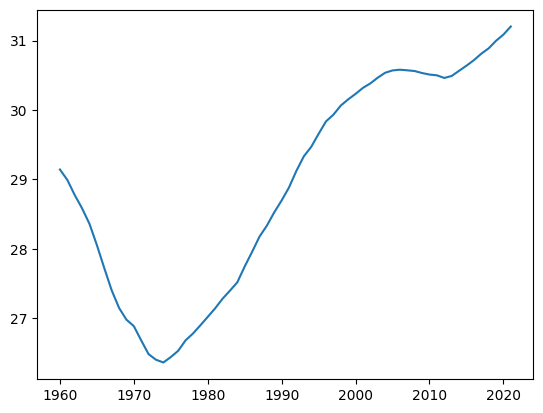

In [309]:
plt.plot(range(1960, 2022), mother_age_at_birth('Netherlands').values)
# 0 equal 1960 so mothers were youger when giving birth during 1965-1980 

In [314]:
# average number of children in a household per year and country
def hh_avg_children(country=None, year=None):
    # Load the dataset
    df = eurostat.get_data_df('lfst_hhnhtych')
    # replace country names
    df['country'] = df['geo\TIME_PERIOD'].replace(eurostat_dictionary)
    # drop unused cols
    filtered_df = df.drop(columns=['freq', 'unit', 'geo\TIME_PERIOD'])
    # use totals for agechild and hhcomp
    filtered_df = filtered_df[filtered_df['agechild'] == 'TOTAL'][filtered_df.hhcomp == 'TOTAL']
    # remove total category from n_child
    filtered_df = filtered_df[filtered_df['n_child'] != 'TOTAL']
    # create numerical n_child column
    filtered_df['n_child'] = filtered_df['n_child'].apply(lambda x: 3 if x == 'GE3' else int(x))
    filtered_df = filtered_df.drop(columns=['agechild', 'hhcomp'])
    # calculate the weighted mean of the number of children per household in each year
    years = [str(i) for i in range(2006,2023)]
    groups = filtered_df.groupby('country')
    for name, group in groups:
        filtered_df.loc[filtered_df.country == name, years] = ((group['n_child'].values[:, np.newaxis] * group[years].values).sum(axis=0)) / (group[years].values.sum(axis=0))
    filtered_df = filtered_df.groupby('country').max()          # use max since rows contain same values
    filtered_df = filtered_df.drop(columns=['n_child'])
    # select country and year
    if country and year:
        out_df = filtered_df.loc[country, year]
    elif country and not year:
        out_df = filtered_df.loc[country, :]
    elif year and not country:
        out_df = filtered_df.loc[:, year]
    else:
        out_df = filtered_df.loc[:, :]
    return out_df   

hh_avg_children().head(5)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
country,,,,,,,,,,,,,,,,,
Austria,0.448054,0.439972,0.431590,0.424385,0.415027,0.407311,0.400342,0.394180,0.387798,0.383134,0.384928,0.383611,0.380028,0.378127,0.375226,0.373450,0.375125
Belgium,0.488778,0.488390,0.478981,0.480787,0.476800,0.478977,0.480320,0.479242,0.482147,0.478267,0.481645,0.475051,0.470752,0.473031,0.463643,0.446719,0.447408
Bulgaria,0.421472,0.394834,0.377360,0.364882,0.352937,0.341485,0.324290,0.346873,0.363804,0.336477,0.368526,0.335951,0.345299,0.354163,0.369310,0.336434,0.328282
Croatia,0.461970,0.508561,0.509054,0.510732,0.539369,0.533460,0.521765,0.508075,0.492364,0.491223,0.483185,0.479443,0.474416,0.466540,0.465777,0.457078,0.441026
Cyprus,0.699686,0.650607,0.655694,0.645138,0.599027,0.579421,0.581473,0.592181,0.581240,0.555592,0.533777,0.527397,0.523708,0.507225,0.505685,0.501455,0.498715


## Combine dataframes

In [316]:
# add new variables (national statistics shared by age groups)
# 2010
df_outcome_2010['mother_age_at_birth'] = [mother_age_at_birth('Netherlands', '2010')]*df_outcome_2010.shape[0]
df_outcome_2010['hh_avg_children'] = [hh_avg_children('Netherlands', '2010')]*df_outcome_2010.shape[0]

# 2020
df_outcome_2020['mother_age_at_birth'] = [mother_age_at_birth('Netherlands', '2020')]*df_outcome_2010.shape[0]
df_outcome_2020['hh_avg_children'] = [hh_avg_children('Netherlands', '2020')]*df_outcome_2010.shape[0]



In [317]:
df_outcome_2010.head()

,country,age,wstatus,2010,unemployment_rate_age_group,youth_getting_married,rent_price_index,inflation_index,minimum_wage_PC_mean_income,mobile_students_from_abroad,PC_eating_fruit,Regulated rental dwellings (%),average_student_debt,total_student_debt_NL,gemiddelde_verkoopprijs_woning,mother_age_at_birth,hh_avg_children
33,Netherlands,Y18-24,EDUC,54.6,10.8,16750.0,85.81,92.05,44.2,195522.0,17.9,"37,12",8100.0,9.500000e+09,239.53,30.510247,0.464366
78,Netherlands,Y18-34,EDUC,49.0,5.9,81445.0,85.81,92.05,44.2,195522.0,None,"37,12",12850.0,9.500000e+09,239.53,30.510247,0.464366
123,Netherlands,Y25-34,EDUC,13.3,3.7,64695.0,85.81,92.05,44.2,195522.0,None,"37,12",16250.0,9.500000e+09,239.53,30.510247,0.464366
168,Netherlands,Y18-24,EMP_FT,23.7,10.8,16750.0,85.81,92.05,44.2,195522.0,17.9,"37,12",8100.0,9.500000e+09,239.53,30.510247,0.464366
213,Netherlands,Y18-34,EMP_FT,28.5,5.9,81445.0,85.81,92.05,44.2,195522.0,None,"37,12",12850.0,9.500000e+09,239.53,30.510247,0.464366


In [318]:
df_outcome_2020.head()

,country,age,wstatus,2020,unemployment_rate_age_group,youth_getting_married,rent_price_index,PC_eating_fruit,mobile_students_from_abroad,minimum_wage_PC_mean_income,inflation_index,Regulated rental dwellings (%),average_student_debt,total_student_debt_NL,gemiddelde_verkoopprijs_woning,mother_age_at_birth,hh_avg_children
33,Netherlands,Y18-24,EDUC,61.8,8.7,8967.0,111.51,24.7,318487.0,43.3,106.96,"33,62",12800.0,2.310000e+10,334.488,31.085623,0.410081
78,Netherlands,Y18-34,EDUC,53.7,5.0,50324.0,111.51,None,318487.0,43.3,106.96,"33,62",15700.0,2.310000e+10,334.488,31.085623,0.410081
123,Netherlands,Y25-34,EDUC,14.1,3.2,41357.0,111.51,None,318487.0,43.3,106.96,"33,62",18100.0,2.310000e+10,334.488,31.085623,0.410081
168,Netherlands,Y18-24,EMP_FT,15.5,8.7,8967.0,111.51,24.7,318487.0,43.3,106.96,"33,62",12800.0,2.310000e+10,334.488,31.085623,0.410081
213,Netherlands,Y18-34,EMP_FT,19.7,5.0,50324.0,111.51,None,318487.0,43.3,106.96,"33,62",15700.0,2.310000e+10,334.488,31.085623,0.410081
